# Fashion MNIST database

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/IBM_AI_Engineering/portfolio-14.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

**Objective**: Build a Deep Neural Network and a Convolutional Neural Network using Pytorch to classify fashion products.

The [Fashion MNIST database](https://en.wikipedia.org/wiki/Fashion_MNIST) is a dataset of 28x28 grayscale images of fashion products, designed to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It consists of 70,000 images, with 60,000 images in the training set and 10,000 images in the test set. Each image is labeled with one of 10 categories:

- T-shirt/top: 0
- Trouser: 1
- Pullover: 2
- Dress: 3
- Coat: 4
- Sandal: 5
- Shirt: 6
- Sneaker: 7
- Bag: 8
- Ankle boot: 9

Fashion MNIST was created to provide a more challenging classification task than the simple MNIST digits dataset. It is freely available and commonly used in machine learning libraries.

## Import libraries

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Load the dataset

In [2]:
# Download training and test data from open datasets
dataset_train = datasets.FashionMNIST(root='/tmp', download=True, transform=ToTensor())
dataset_right = datasets.FashionMNIST(root='/tmp', train=False, download=True, transform=ToTensor())
dataset_validation, dataset_test = random_split(dataset_right, [int(len(dataset_right)/2), int(len(dataset_right)/2)])
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Create data loaders
dataloader_train = DataLoader(dataset_train, batch_size=32)
dataloader_validation = DataLoader(dataset_validation, batch_size=32)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test))

print("Number of training samples:", len(dataset_train))
print("Number of validation samples:", len(dataset_validation))
print("Number of test samples:", len(dataset_test))
print("Image size:", tuple(dataset_train[0][0].shape))

Number of training samples: 60000
Number of validation samples: 5000
Number of test samples: 5000
Image size: (1, 28, 28)


## Visualize the dataset

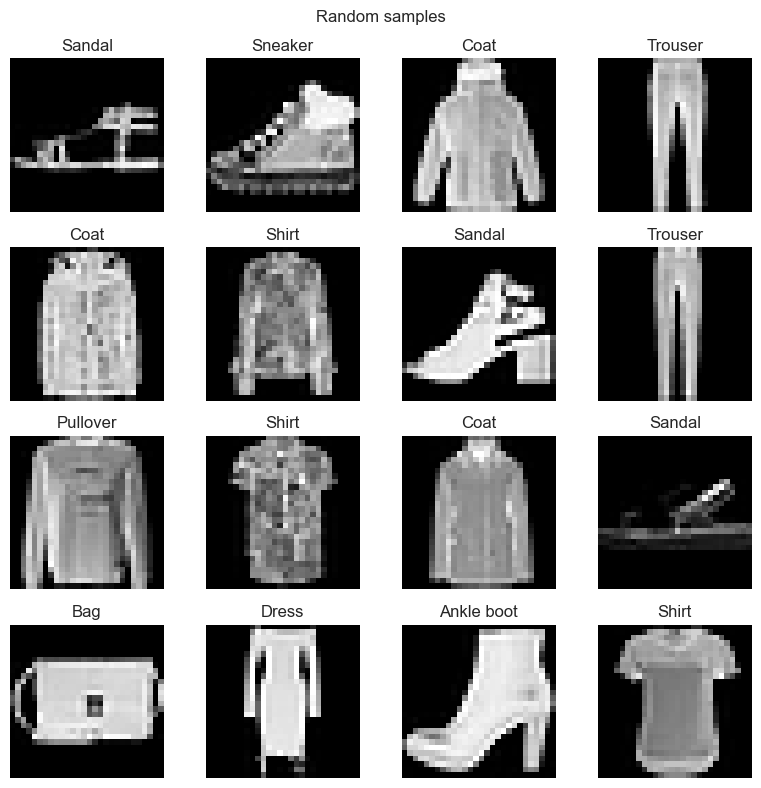

In [3]:
indexes = np.random.choice(range(0, len(dataset_train)), size=16, replace=False)
samples = [(dataset_train[index][0], dataset_train[index][1]) for index in indexes]

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for ax, sample in zip(axs.flatten(), samples):
    ax.imshow(sample[0][0], cmap="gray")
    ax.set_title(classes[sample[1]])
    ax.axis("off")

plt.tight_layout()
plt.show()

## Visualize the class distribution

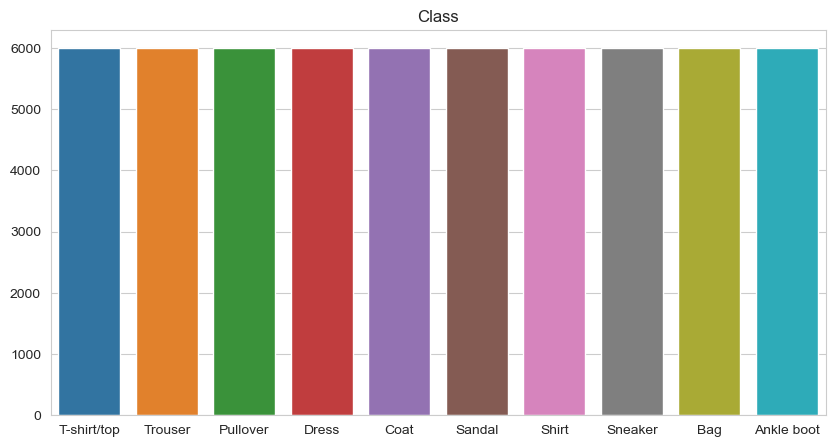

In [4]:
_, y_train = zip(*dataset_train)
labels, sizes = np.unique(y_train, return_counts=True)
labels = [classes[label] for label in labels]

plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=sizes, hue=labels, palette="tab10", legend=False)
plt.title("Class")
plt.show()

## Build a Deep Neural Network

In [5]:
# Get cpu, gpu or mps device for training
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device!\n")

# Define model
class DeepNeuralNetwork(nn.Module):
    def __init__(self, number_pixels, number_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(nn.Linear(number_pixels, 512),
                                               nn.ReLU(),
                                               nn.Linear(512, 512),
                                               nn.ReLU(),
                                               nn.Linear(512, number_classes))

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

number_pixels = dataset_train[0][0].shape[1]**2
number_classes = np.unique(y_train).size

model_DNN = DeepNeuralNetwork(number_pixels, number_classes).to(device)
print(model_DNN)

Using cuda device!

DeepNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Compile and train the model

In [6]:
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    number_batches = len(dataloader)
    model.train()
    train_loss, train_accuracy = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        y_pred = model(X)
        loss = loss_function(y_pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        train_accuracy += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= number_batches
    train_accuracy /= size

    return train_accuracy, train_loss

def validation(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    number_batches = len(dataloader)
    model.eval()
    validation_loss, validation_accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_function(y_pred, y)
            validation_loss += loss.item()
            validation_accuracy += (y_pred.argmax(1) == y).type(torch.float).sum().item()
            
    validation_loss /= number_batches
    validation_accuracy /= size

    return validation_accuracy, validation_loss

In [7]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_DNN.parameters())

epochs = 10
history_DNN = {"accuracy": [], "loss": [], "val_accuracy": [], "val_loss": []}

for epoch in range(epochs):
    start_time = datetime.now()
    accuracy, loss = train(dataloader_train, model_DNN, loss_function, optimizer)
    val_accuracy, val_loss = validation(dataloader_validation, model_DNN, loss_function)
    stop_time = datetime.now()

    history_DNN["accuracy"].append(accuracy)
    history_DNN["loss"].append(loss)
    history_DNN["val_accuracy"].append(val_accuracy)
    history_DNN["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"\telapsed time: {(stop_time - start_time).total_seconds():.3f}s - accuracy: {accuracy:.4f} - loss: {loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")

Epoch 1/10
	elapsed time: 7.723s - accuracy: 0.8243 - loss: 0.4774 - val_accuracy: 0.8460 - val_loss: 0.4124
Epoch 2/10
	elapsed time: 7.490s - accuracy: 0.8682 - loss: 0.3565 - val_accuracy: 0.8548 - val_loss: 0.4009
Epoch 3/10
	elapsed time: 7.316s - accuracy: 0.8820 - loss: 0.3190 - val_accuracy: 0.8586 - val_loss: 0.3867
Epoch 4/10
	elapsed time: 7.289s - accuracy: 0.8900 - loss: 0.2923 - val_accuracy: 0.8736 - val_loss: 0.3566
Epoch 5/10
	elapsed time: 7.211s - accuracy: 0.8964 - loss: 0.2736 - val_accuracy: 0.8722 - val_loss: 0.3544
Epoch 6/10
	elapsed time: 7.157s - accuracy: 0.9024 - loss: 0.2569 - val_accuracy: 0.8776 - val_loss: 0.3420
Epoch 7/10
	elapsed time: 7.192s - accuracy: 0.9081 - loss: 0.2407 - val_accuracy: 0.8790 - val_loss: 0.3614
Epoch 8/10
	elapsed time: 7.223s - accuracy: 0.9114 - loss: 0.2303 - val_accuracy: 0.8742 - val_loss: 0.3758
Epoch 9/10
	elapsed time: 7.097s - accuracy: 0.9159 - loss: 0.2190 - val_accuracy: 0.8754 - val_loss: 0.3882
Epoch 10/10
	elapse

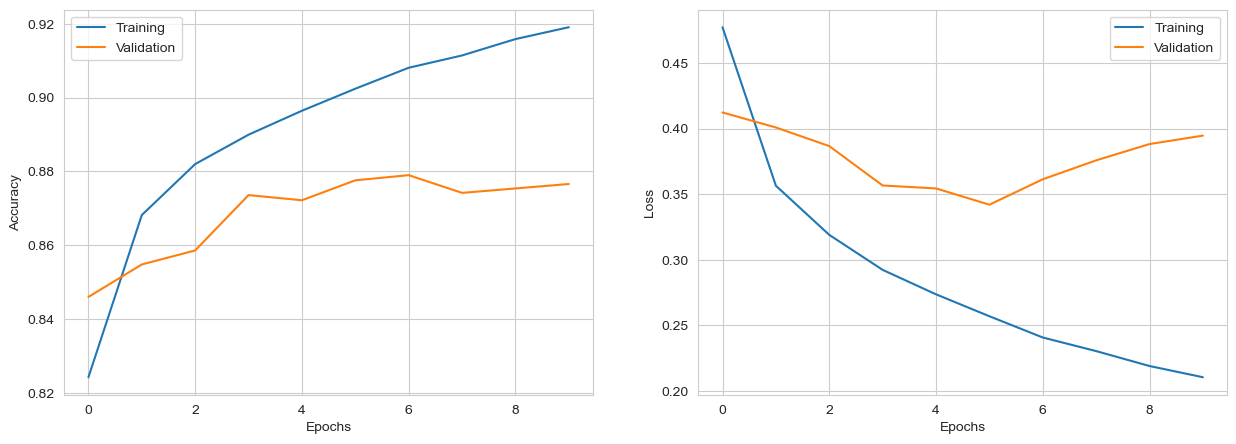

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_DNN['accuracy'])
ax1.plot(history_DNN['val_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history_DNN['loss'])
ax2.plot(history_DNN['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

## Evaluate the model

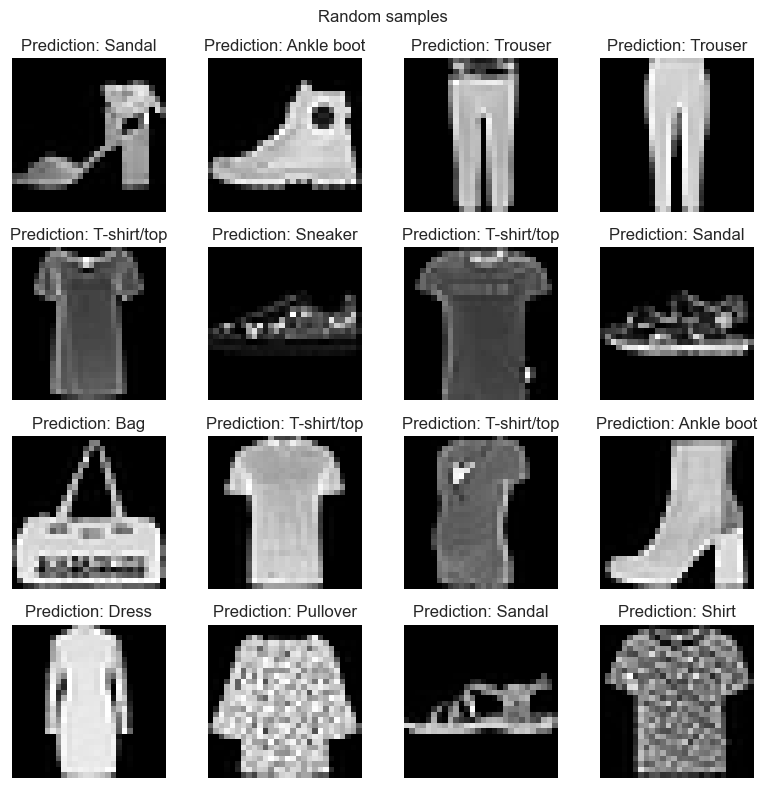

In [9]:
indexes = np.random.choice(range(0, len(dataset_test)), size=16, replace=False)
images = [dataset_test[index][0] for index in indexes]

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

with torch.no_grad():
    for image, ax in zip(images, axs.flatten()):
        X = torch.unsqueeze(image, 0).to(device)
        prediction_logits = model_DNN(X)
        ax.imshow(image[0], cmap="gray")
        ax.set_title("Prediction: " + classes[prediction_logits.argmax(1).item()])
        ax.axis("off")

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0     0.8056    0.8484    0.8265       508
           1     0.9771    0.9771    0.9771       524
           2     0.8103    0.6868    0.7435       479
           3     0.9093    0.8698    0.8891       484
           4     0.6962    0.8696    0.7733       506
           5     0.9816    0.9466    0.9638       506
           6     0.7224    0.6227    0.6688       493
           7     0.9276    0.9785    0.9524       511
           8     0.9734    0.9834    0.9784       483
           9     0.9640    0.9526    0.9583       506

    accuracy                         0.8752      5000
   macro avg     0.8767    0.8736    0.8731      5000
weighted avg     0.8773    0.8752    0.8742      5000



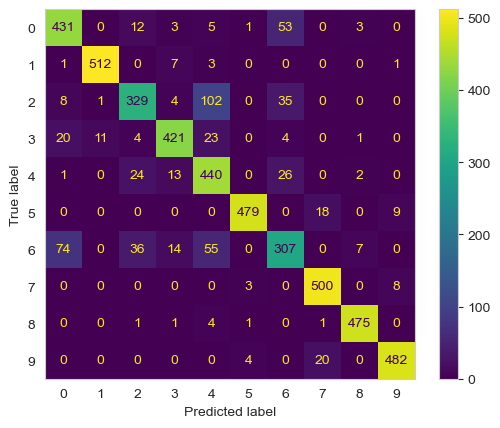

In [10]:
with torch.no_grad():
    for X_test, y_test in dataloader_test:
        X_test = X_test.to(device)
        y_pred = model_DNN(X_test).argmax(1).cpu().numpy()

print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.grid(False)
plt.show()

## Build a Convolutional Neural Network

In [11]:
# Get cpu, gpu or mps device for training
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device!\n")

# Define model
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, number_classes):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            # Channel width after this layer: 28
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2), # The reason we start with 1 channel is because we have a single black and white image
            nn.ReLU(),
            # Channel width after this layer: 14
            nn.MaxPool2d(kernel_size=2),
            # Channel width after this layer: 14
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            # Channel width after this layer: 7
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(), # Flatten the output of the convolutional layers
            nn.Linear(32*7*7, number_classes)) # In total we have 32 channels which are each 7 * 7 in size

    def forward(self, x):
        logits = self.linear_relu_stack(x)

        return logits

number_classes = np.unique(y_train).size

model_CNN = ConvolutionalNeuralNetwork(number_classes).to(device)
print(model_CNN)

Using cuda device!

ConvolutionalNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=10, bias=True)
  )
)


## Compile and train the model

In [12]:
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    number_batches = len(dataloader)
    model.train()
    train_loss, train_accuracy = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        y_pred = model(X)
        loss = loss_function(y_pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        train_accuracy += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= number_batches
    train_accuracy /= size

    return train_accuracy, train_loss

def validation(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    number_batches = len(dataloader)
    model.eval()
    validation_loss, validation_accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_function(y_pred, y)
            validation_loss += loss.item()
            validation_accuracy += (y_pred.argmax(1) == y).type(torch.float).sum().item()
            
    validation_loss /= number_batches
    validation_accuracy /= size

    return validation_accuracy, validation_loss

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters())

epochs = 10
history_CNN = {"accuracy": [], "loss": [], "val_accuracy": [], "val_loss": []}

for epoch in range(epochs):
    start_time = datetime.now()
    accuracy, loss = train(dataloader_train, model_CNN, loss_function, optimizer)
    val_accuracy, val_loss = validation(dataloader_validation, model_CNN, loss_function)
    stop_time = datetime.now()

    history_CNN["accuracy"].append(accuracy)
    history_CNN["loss"].append(loss)
    history_CNN["val_accuracy"].append(val_accuracy)
    history_CNN["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"\telapsed time: {(stop_time - start_time).total_seconds():.3f}s - accuracy: {accuracy:.4f} - loss: {loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")

Epoch 1/10
	elapsed time: 8.178s - accuracy: 0.8367 - loss: 0.4540 - val_accuracy: 0.8682 - val_loss: 0.3734
Epoch 2/10
	elapsed time: 8.057s - accuracy: 0.8880 - loss: 0.3133 - val_accuracy: 0.8852 - val_loss: 0.3231
Epoch 3/10
	elapsed time: 7.972s - accuracy: 0.9032 - loss: 0.2691 - val_accuracy: 0.8936 - val_loss: 0.3018
Epoch 4/10
	elapsed time: 8.063s - accuracy: 0.9129 - loss: 0.2406 - val_accuracy: 0.8996 - val_loss: 0.2909
Epoch 5/10
	elapsed time: 8.099s - accuracy: 0.9212 - loss: 0.2188 - val_accuracy: 0.9038 - val_loss: 0.2829
Epoch 6/10
	elapsed time: 7.912s - accuracy: 0.9270 - loss: 0.2013 - val_accuracy: 0.9066 - val_loss: 0.2834
Epoch 7/10
	elapsed time: 7.968s - accuracy: 0.9319 - loss: 0.1874 - val_accuracy: 0.9086 - val_loss: 0.2817
Epoch 8/10
	elapsed time: 7.987s - accuracy: 0.9368 - loss: 0.1747 - val_accuracy: 0.9104 - val_loss: 0.2808
Epoch 9/10
	elapsed time: 8.043s - accuracy: 0.9406 - loss: 0.1637 - val_accuracy: 0.9084 - val_loss: 0.2950
Epoch 10/10
	elapse

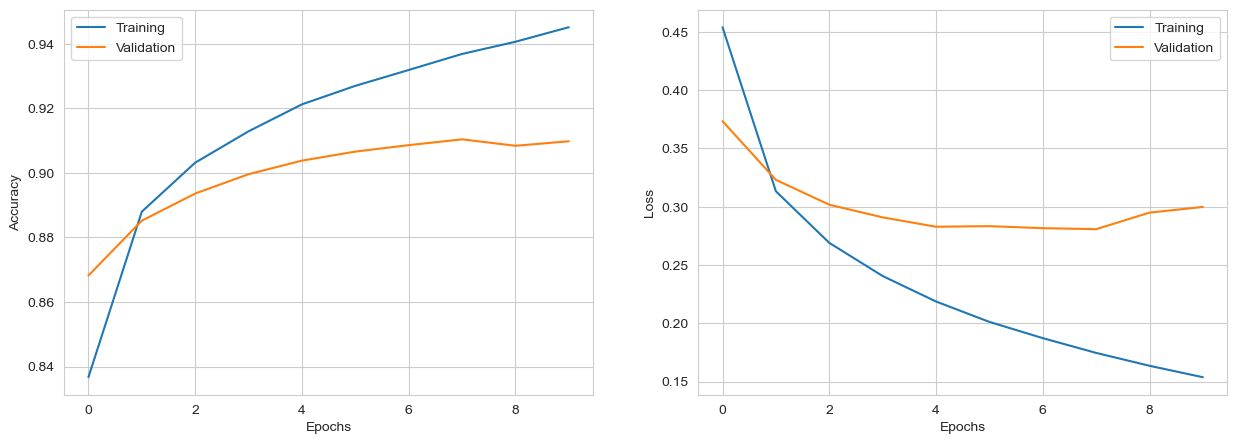

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_CNN['accuracy'])
ax1.plot(history_CNN['val_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history_CNN['loss'])
ax2.plot(history_CNN['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

## Evaluate the model

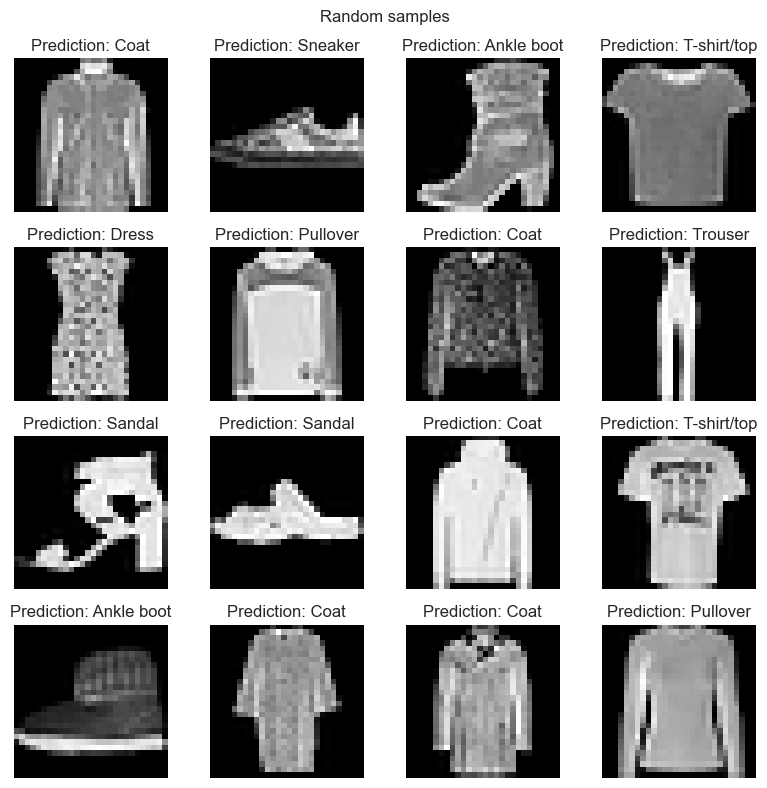

In [15]:
indexes = np.random.choice(range(0, len(dataset_test)), size=16, replace=False)
images = [dataset_test[index][0] for index in indexes]

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

with torch.no_grad():
    for image, ax in zip(images, axs.flatten()):
        X = torch.unsqueeze(image, 0).to(device)
        prediction_logits = model_CNN(X)
        ax.imshow(image[0], cmap="gray")
        ax.set_title("Prediction: " + classes[prediction_logits.argmax(1).item()])
        ax.axis("off")

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0     0.8070    0.9134    0.8569       508
           1     0.9922    0.9771    0.9846       524
           2     0.8632    0.8434    0.8532       479
           3     0.8762    0.9504    0.9118       484
           4     0.8105    0.8874    0.8472       506
           5     0.9860    0.9723    0.9791       506
           6     0.8486    0.6024    0.7046       493
           7     0.9280    0.9843    0.9554       511
           8     0.9814    0.9814    0.9814       483
           9     0.9836    0.9486    0.9658       506

    accuracy                         0.9070      5000
   macro avg     0.9077    0.9061    0.9040      5000
weighted avg     0.9081    0.9070    0.9047      5000



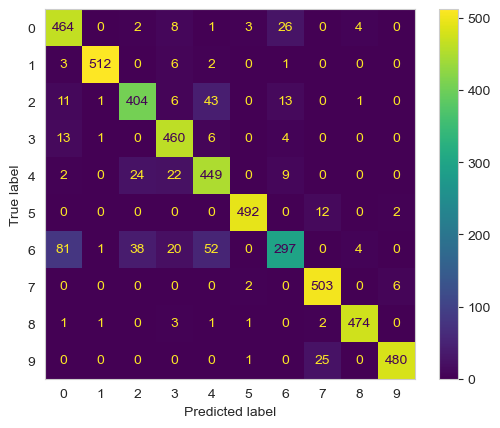

In [16]:
with torch.no_grad():
    for X_test, y_test in dataloader_test:
        X_test = X_test.to(device)
        y_pred = model_CNN(X_test).argmax(1).cpu().numpy()

print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.grid(False)
plt.show()